In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Embedding, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import model_to_dot
from tqdm import tqdm,trange

# Set parameters

In [2]:
num_train_examples = 100000
max_train_length = 10

num_test_examples = 10000
min_test_length=5
max_test_length=100
step_test_length=5

# Generate train data

In [3]:
X = np.zeros((num_train_examples,max_train_length))
sum_X = np.zeros((num_train_examples))
for i in tqdm(range(num_train_examples), desc='Generating train examples: '):
    n = np.random.randint(1,max_train_length)
    for j in range(1,n+1):
        X[i,-j] = 1.
#     np.random.shuffle(X[i])
    sum_X[i] = np.sum(X[i]) % 2

Generating train examples: 100%|████████████████████████████████████████████| 100000/100000 [00:01<00:00, 76333.12it/s]


In [4]:
print(X[0:10])
print(sum_X[0:10])

[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]]
[1. 0. 0. 0. 1. 1. 0. 1. 0. 1.]


# Generate test data

In [5]:
def gen_test_data(num_examples, length):
    Y = np.zeros((num_examples, length))
    sum_Y = np.zeros((num_examples))
    for i in range(num_examples):
        for j in range(1,length+1):
            Y[i,-j] = np.random.randint(0,2)
#         np.random.shuffle(Y[i])
        sum_Y[i] = np.sum(Y[i]) % 2
    return Y, sum_Y

# DeepSet Model

In [11]:
def get_deepset_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(2, 100, mask_zero=False)(input_txt)
    x = Dense(30, activation='tanh')(x)
    Adder = Lambda(lambda x: K.sum(x, axis=1), output_shape=(lambda shape: (shape[0], shape[2])))
    x = Adder(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4, epsilon=1e-3)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# LSTM Model

In [17]:
def get_lstm_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(2, 100, mask_zero=False)(input_txt)
    x = LSTM(50)(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# GRU Model

In [18]:
def get_gru_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(2, 100, mask_zero=False)(input_txt)
    x = GRU(80)(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# Train Deepset model

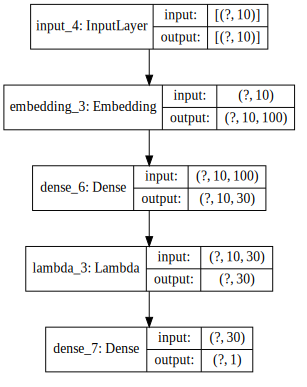

In [19]:
# model
model = get_deepset_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [20]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=100, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights.hdf5')

# save weights
deep_we = []
for i in [1,2,4]:
    w = model.get_layer(index=i).get_weights()
    deep_we.append(w)

Epoch 1/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4537 - val_loss: 0.4374
Epoch 2/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4427 - val_loss: 0.4370
Epoch 3/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4427 - val_loss: 0.4355
Epoch 4/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4427 - val_loss: 0.4354
Epoch 5/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4427 - val_loss: 0.4374
Epoch 6/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4429 - val_loss: 0.4371
Epoch 7/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4429 - val_loss: 0.4356
Epoch 8/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4429 - val_loss: 0.4363
Epoch 9/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4427 - val_loss: 0.4365
Epoch 10/100
772/772 [==============================] - 2s 2ms/step - loss: 0.4429 - val_lo

# Train LSTM model

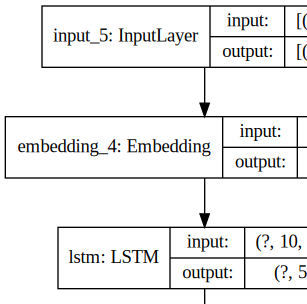

In [21]:
# model
model = get_lstm_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [22]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights1.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=50, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights1.hdf5')

# save weights
lstm_we = []
for i in [1,2,3]:
    w = model.get_layer(index=i).get_weights()
    lstm_we.append(w)

Epoch 1/50
772/772 [==============================] - 7s 10ms/step - loss: 0.4600 - val_loss: 0.4348
Epoch 2/50
772/772 [==============================] - 7s 9ms/step - loss: 0.4404 - val_loss: 0.4342
Epoch 3/50
772/772 [==============================] - 7s 9ms/step - loss: 0.4370 - val_loss: 0.4314
Epoch 4/50
772/772 [==============================] - 8s 10ms/step - loss: 0.4268 - val_loss: 0.4206
Epoch 5/50
772/772 [==============================] - 8s 10ms/step - loss: 0.4146 - val_loss: 0.4138
Epoch 6/50
772/772 [==============================] - 8s 10ms/step - loss: 0.3957 - val_loss: 0.3797
Epoch 7/50
772/772 [==============================] - 8s 10ms/step - loss: 0.3371 - val_loss: 0.3137
Epoch 8/50
772/772 [==============================] - 7s 9ms/step - loss: 0.2390 - val_loss: 0.1374
Epoch 9/50
772/772 [==============================] - 8s 10ms/step - loss: 0.0313 - val_loss: 0.0047
Epoch 10/50
772/772 [==============================] - 9s 11ms/step - loss: 0.0035 - val_loss:

# Train GRU model

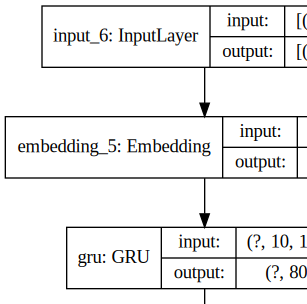

In [23]:
# model
model = get_gru_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [24]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights2.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=50, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights2.hdf5')

# save weights
gru_we = []
for i in [1,2,3]:
    w = model.get_layer(index=i).get_weights()
    gru_we.append(w)

Epoch 1/50
772/772 [==============================] - 10s 13ms/step - loss: 0.4577 - val_loss: 0.4360
Epoch 2/50
772/772 [==============================] - 9s 12ms/step - loss: 0.4401 - val_loss: 0.4324
Epoch 3/50
772/772 [==============================] - 9s 11ms/step - loss: 0.4370 - val_loss: 0.4286
Epoch 4/50
772/772 [==============================] - ETA: 0s - loss: 0.428 - 9s 12ms/step - loss: 0.4286 - val_loss: 0.4161
Epoch 5/50
772/772 [==============================] - 9s 12ms/step - loss: 0.4049 - val_loss: 0.3911
Epoch 6/50
772/772 [==============================] - 9s 12ms/step - loss: 0.3709 - val_loss: 0.3119
Epoch 7/50
772/772 [==============================] - 9s 11ms/step - loss: 0.1291 - val_loss: 0.0071
Epoch 8/50
772/772 [==============================] - 9s 12ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 9/50
772/772 [==============================] - 9s 12ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 10/50
772/772 [==============================] - 9s 12ms/ste

# Evaluate models

In [25]:
metrics = {'deepsets': {'acc':[], 'mae':[], 'mse':[]}, 'lstm': {'acc':[], 'mae':[], 'mse':[]}, 'gru': {'acc':[], 'mae':[], 'mse':[]}}

lengths = range(min_test_length, max_test_length, step_test_length)
for l in lengths:
    print('Evaluating at length: ', l)
    K.clear_session()
    
    # generate test data
    Y, sum_Y = gen_test_data(num_test_examples, l)

    # model
    model = get_deepset_model(l)

    # load weights
    for i, idx in enumerate([1,2,4]):
        model.get_layer(index=idx).set_weights(deep_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['deepsets']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['deepsets']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['deepsets']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))
    
    # model
    model = get_lstm_model(l)

    # load weights
    for i, idx in enumerate([1,2,3]):
        model.get_layer(index=idx).set_weights(lstm_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['lstm']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['lstm']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['lstm']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))
    
    # model
    model = get_gru_model(l)

    # load weights
    for i, idx in enumerate([1,2,3]):
        model.get_layer(index=idx).set_weights(gru_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['gru']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['gru']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['gru']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))

Evaluating at length:  5
79/79 [==============================] - 0s 4ms/step
Evaluating at length:  10
79/79 [==============================] - 0s 5ms/step
Evaluating at length:  15
79/79 [==============================] - 0s 6ms/step
Evaluating at length:  20
79/79 [==============================] - 1s 7ms/step
Evaluating at length:  25
79/79 [==============================] - 1s 9ms/step
Evaluating at length:  30
79/79 [==============================] - 1s 12ms/step
Evaluating at length:  35
79/79 [==============================] - 1s 14ms/step
Evaluating at length:  40
79/79 [==============================] - 1s 15ms/step
Evaluating at length:  45
79/79 [==============================] - 1s 16ms/step
Evaluating at length:  50
79/79 [==============================] - 1s 18ms/step
Evaluating at length:  55
79/79 [==============================] - 2s 20ms/step
Evaluating at length:  60
79/79 [==============================] - 2s 21ms/step
Evaluating at length:  65
79/79 [=============

Compare the performance

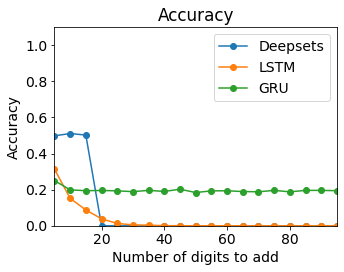

In [26]:
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))

plt.plot(lengths, metrics['deepsets']['acc'], 'o-')
plt.plot(lengths, metrics['lstm']['acc'], 'o-')
plt.plot(lengths, metrics['gru']['acc'], 'o-')
plt.xlabel('Number of digits to add')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.ylim( 0, 1.1 )
plt.xlim( 5, 95 )
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.show()

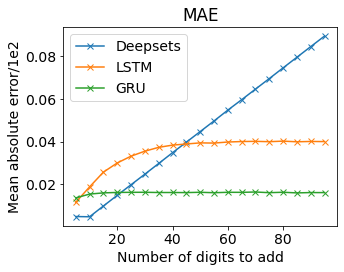

In [27]:
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))

plt.plot(lengths, np.array(metrics['deepsets']['mae'])/1e2, 'x-')
plt.plot(lengths, np.array(metrics['lstm']['mae'])/1e2, 'x-')
plt.plot(lengths, np.array(metrics['gru']['mae'])/1e2, 'x-')
plt.xlabel('Number of digits to add')
plt.ylabel('Mean absolute error/1e2')
plt.title('MAE')
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.show()

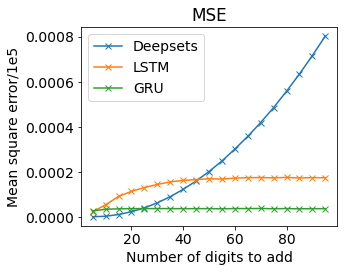

In [28]:
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))

plt.plot(lengths, np.array(metrics['deepsets']['mse'])/1e5, 'x-')
plt.plot(lengths, np.array(metrics['lstm']['mse'])/1e5, 'x-')
plt.plot(lengths, np.array(metrics['gru']['mse'])/1e5, 'x-')
plt.xlabel('Number of digits to add')
plt.ylabel('Mean square error/1e5')
plt.title('MSE')
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.show()